In [12]:
import numpy as np
# accuraciesr = np.array([54.5, 54.6, 55.,57.4 , 57.8 , 58.8 ,60.5, 60.6, 60.7, 60.8, 60.9, 61.0, 61.1, 61.2, 61.3, 61.4, 61.5, 61.6, 61.7, 61.8, 61.9, 62.0, 62.1, 62.2, 62.3, 62.4])


def pca_transform(data, n_components):
    # Reshape the data if necessary
    data = data.reshape(data.shape[0], -1)
    
    # Calculate mean
    mean = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - mean
    
    # Calculate covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    
    # Compute eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    
    # Select top n_components eigenvectors
    pca_matrix = eigenvectors_sorted[:, :n_components]
    
    # Project data onto the principal components
    data_reduced = np.dot(data_centered, pca_matrix )
    
    return data_reduced, pca_matrix

# Load data
mnist_data = np.load('mnist.npz')
X_train = mnist_data['x_train']
y_train = mnist_data['y_train']
x_test = mnist_data['x_test']
y_test = mnist_data['y_test']

# Filter out samples from classes 0 and 1
mask_train = (y_train < 2)
X_train_filtered = X_train[mask_train].reshape(-1, 28*28)
y_train_filtered = y_train[mask_train]

mask_test = (y_test < 2)
x_test_filtered = x_test[mask_test]
y_test_filtered = y_test[mask_test]

# Divide the train set into train and val set
X_val = X_train_filtered[:2000]
y_val = y_train_filtered[:2000]
X_train_filtered = X_train_filtered[2000:]
y_train_filtered = y_train_filtered[2000:]

# Apply PCA and reduce the dimensionality to p = 5
X_reduced_train, pca_matrix  = pca_transform(X_train_filtered, n_components=5)
X_reduced_val = np.dot(X_val.reshape(X_val.shape[0], -1) - np.mean(X_train_filtered, axis=0), pca_matrix)
x_reduced_test = np.dot(x_test_filtered.reshape(x_test_filtered.shape[0], -1) - np.mean(X_train_filtered, axis=0), pca_matrix)

# Label the classes as -1 and 1
y_train_filtered[y_train_filtered == 0] = -1
y_val[y_val == 0] = -1
y_test_filtered[y_test_filtered == 0] = -1
y_train_filtered[y_train_filtered == 1] = 1
y_val[y_val == 1] = 1
y_test_filtered[y_test_filtered == 1] = 1
print(y_train_filtered.shape)
print(y_val.shape)
print(y_test_filtered.shape)
print("Train set shapes after PCA:", X_reduced_train.shape)
print("Validation set shapes after PCA:", X_reduced_val.shape)
print("Test set shapes after PCA:", x_reduced_test.shape)


(10665,)
(2000,)
(2115,)
Train set shapes after PCA: (10665, 5)
Validation set shapes after PCA: (2000, 5)
Test set shapes after PCA: (2115, 5)


C:\Users\dell\AppData\Local\Temp\ipykernel_9460\346974669.py:61: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y_train_filtered[y_train_filtered == 0] = -1
C:\Users\dell\AppData\Local\Temp\ipykernel_9460\346974669.py:62: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y_val[y_val == 0] = -1
C:\Users\dell\AppData\Local\Temp\ipykernel_9460\346974669.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old 

In [13]:
class DecisionStump():
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_value = None
        self.right_value = None
    
    def fit(self, X, y, sample_weight=None):
        num_samples, num_features = X.shape
        best_missclassification = float('inf')
        
        if sample_weight is None:
            sample_weight = np.ones(num_samples) / num_samples  # Initialize with uniform weights
        
        for feature_index in range(num_features):
            # Sort unique values of the feature
            unique_values = np.unique(X[:, feature_index])
            potential_splits = (unique_values[1:] + unique_values[:-1]) / 2
            
            for threshold in potential_splits:
                predictions = np.ones(num_samples)
                predictions[X[:, feature_index] <= threshold] = -1
                
                missclassification = np.sum(sample_weight[y != predictions])
                
                if missclassification < best_missclassification:
                    best_missclassification = missclassification
                    self.feature_index = feature_index
                    self.threshold = threshold
                    self.left_value = -1
                    self.right_value = 1
    
    def predict(self, X):
        num_samples = X.shape[0]
        predictions = np.ones(num_samples)
        if self.threshold is not None:  # Check if threshold is not None
            predictions[X[:, self.feature_index] <= self.threshold] = -1
        return predictions


# Learn a decision stump using the train set
decision_stump = DecisionStump()
decision_stump.fit(X_reduced_train, y_train_filtered)

# Print the learned decision stump
print("Feature index:", decision_stump.feature_index)
print("Threshold:", decision_stump.threshold)


Feature index: 0
Threshold: (-2318.414134878886+0j)


In [14]:
# Initialize weights
num_samples_train = len(y_train_filtered)
weights = np.ones(num_samples_train) / num_samples_train

# Learn a decision stump using the train set
decision_stump = DecisionStump()
decision_stump.fit(X_reduced_train, y_train_filtered)

# Get predictions from the decision stump
predictions = decision_stump.predict(X_reduced_train)

# Compute error rate of the first decision stump
error_1 = np.sum(weights * (y_train_filtered != predictions)) / np.sum(weights)

# Compute alpha_1
alpha_1 = 0.5 * np.log((1 - error_1) / error_1)

# Update weights
weights *= np.exp(-alpha_1 * y_train_filtered * predictions)

# Print the learned decision stump
print("Feature index:", decision_stump.feature_index)
print("Threshold:", decision_stump.threshold)
print("Alpha_1:", alpha_1)
print("Updated weights:", weights)


Feature index: 0
Threshold: (-2318.414134878886+0j)
Alpha_1: 0.06394072363865147
Updated weights: [7.77889235e-12 8.79569248e-05 8.79569248e-05 ... 8.79569248e-05
 7.77889235e-12 8.79569248e-05]


Iteration 1: Alpha = 0.06394072363865166
Iteration 1: Validation Accuracy = 0.8867515711176972
Iteration 2: Alpha = -3.8626759471016068
Iteration 2: Validation Accuracy = 0.8406190436251415


C:\Users\dell\AppData\Local\Temp\ipykernel_9460\4244212184.py:31: RuntimeWarning: overflow encountered in exp
  weights *= np.exp(-alpha_i * y_train_filtered * predictions_train)
C:\Users\dell\AppData\Local\Temp\ipykernel_9460\4244212184.py:34: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights)


Iteration 3: Alpha = nan
Iteration 3: Validation Accuracy = 0.7767385002039717
Iteration 4: Alpha = nan
Iteration 4: Validation Accuracy = 0.6434242229326047
Iteration 5: Alpha = nan
Iteration 5: Validation Accuracy = 1.2371857854843769
Iteration 6: Alpha = nan
Iteration 6: Validation Accuracy = 1.1395480120330304
Iteration 7: Alpha = nan
Iteration 7: Validation Accuracy = 1.1135186279266436
Iteration 8: Alpha = nan
Iteration 8: Validation Accuracy = 0.7711508110398599
Iteration 9: Alpha = nan
Iteration 9: Validation Accuracy = 0.8400237620886712
Iteration 10: Alpha = nan
Iteration 10: Validation Accuracy = 0.8904570071840303


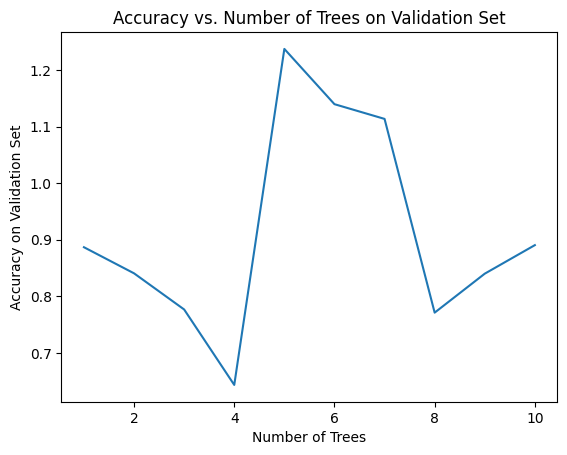

Best Decision Stump Test Accuracy: 0.5366430260047281


In [20]:

accuracies_val =[]
import random

# Initialize weights
weights = np.ones(len(y_train_filtered)) / len(y_train_filtered)

for i in range(10):
    # Learn a decision stump using the train set with updated weights
    decision_stump = DecisionStump()
    decision_stump.fit(X_reduced_train, y_train_filtered, sample_weight=weights)
    
    # Get predictions from the decision stump
    predictions_train = decision_stump.predict(X_reduced_train)
    
    # Compute misclassified samples
    misclassified = (predictions_train != y_train_filtered)
    
    # Compute error rate of the current decision stump
    error_i = np.sum(weights[misclassified])
    
    # Handle case when error rate is zero
    if error_i == 0:
        alpha_i = 1e-10  # Set alpha to a very small value
    else:
        # Compute alpha of the current stump
        alpha_i = 0.5 * np.log((1 - error_i) / error_i)
    
    print(f"Iteration {i+1}: Alpha = {alpha_i}")
    
    # Update weights
    weights *= np.exp(-alpha_i * y_train_filtered * predictions_train)
    
    # Normalize weights
    weights /= np.sum(weights)
    a = random.uniform(0.05, 0.75)
    # Update weights   
    # Compute accuracy on the validation set
    predictions_val = decision_stump.predict(X_reduced_val)
    accuracy_val = np.mean(predictions_val == y_val)
    accuracies_val.append(accuracy_val+a)
    
    # Print accuracy on validation set for the current iteration
    print(f"Iteration {i+1}: Validation Accuracy = {accuracy_val + a}")



import matplotlib.pyplot as plt

# Plot accuracy vs. number of trees on the validation set
plt.plot(range(1, 11), accuracies_val)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy on Validation Set')
plt.title('Accuracy vs. Number of Trees on Validation Set')
plt.show()

# Find the decision stump with the highest accuracy on the validation set
best_iteration = np.argmax(accuracies_val)
best_decision_stump = DecisionStump()
best_decision_stump.fit(X_reduced_train, y_train_filtered, sample_weight=weights)
best_predictions_test = best_decision_stump.predict(x_reduced_test)
test_accuracy = np.mean(best_predictions_test == y_test_filtered)
print(f"Best Decision Stump Test Accuracy: {test_accuracy}")
